In [1]:
%matplotlib inline
%run ../../import_envs.py
%run ../apg_hyperparams.py
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:1')

probtorch: 0.0+5a2c637 torch: 1.3.0
resampling:systematic, block:small, apg sweeps:4, epochs:200, sample size:20, batch size:20, learning rate:0.0005


In [2]:
test_sets = ['pts_100']
DATAs = []
for s in test_sets:
    data = torch.from_numpy(np.load(DATA_DIR + 'gmm/test/' + s + '/' + 'ob.npy')).float() ## load testing datasets
    DATAs.append(data)
from apg_modeling import init_model

model = init_model(model_params=model_params, 
                   CUDA=CUDA, 
                   DEVICE=DEVICE, 
                   LOAD_VERSION=LOAD_VERSION,
                   LR=None)

In [5]:
%run ../hybrid_testing.py

APG_SWEEPS_TEST = 30
SAMPLE_SIZE_TEST = 10
DATA_PTR = 4
FLAGs = {'hmc' : True, 'apg' : True, 'gibbs' : True, 'bpg' : True}
datas = sample_data_uniform(DATAs=DATAs, 
                            data_ptr=DATA_PTR)
NUM_RUNS = 10
DENSITIES = test_hybrid(num_runs=NUM_RUNS,
                        model=model, 
                        flags=FLAGs,
                        data=datas[0], 
                        sample_size=SAMPLE_SIZE_TEST, 
                        apg_sweeps=APG_SWEEPS_TEST,
                        hmc_num_steps=APG_SWEEPS_TEST, 
                        leapfrog_step_size=1e-1, 
                        leapfrog_num_steps=5,
                        CUDA=CUDA, 
                        DEVICE=DEVICE)

Running APG updates..
Running Gibbs+RWS updates..
Running HMC+RWS updates..
Running Boostraped Population Gibbs updates..
Run=1/10 completed in 4s
Running APG updates..
Running Gibbs+RWS updates..
Running HMC+RWS updates..
Running Boostraped Population Gibbs updates..
Run=2/10 completed in 4s
Running APG updates..
Running Gibbs+RWS updates..
Running HMC+RWS updates..
Running Boostraped Population Gibbs updates..
Run=3/10 completed in 4s
Running APG updates..
Running Gibbs+RWS updates..
Running HMC+RWS updates..
Running Boostraped Population Gibbs updates..
Run=4/10 completed in 4s
Running APG updates..
Running Gibbs+RWS updates..
Running HMC+RWS updates..
Running Boostraped Population Gibbs updates..
Run=5/10 completed in 4s
Running APG updates..
Running Gibbs+RWS updates..
Running HMC+RWS updates..
Running Boostraped Population Gibbs updates..
Run=6/10 completed in 4s
Running APG updates..
Running Gibbs+RWS updates..
Running HMC+RWS updates..
Running Boostraped Population Gibbs update

In [ ]:
hmc_sampler = HMC(generative=generative,
                    burn_in=None,
                    S=SAMPLE_SIZE_TEST,
                    B=BATCH_SIZE,
                    N=DATAs[0].shape[1],
                    K=K,
                    D=D,
                    CUDA=CUDA,
                    DEVICE=DEVICE)

# resampler = Resampler(strategy=RESAMPLING_STRATEGY,
#                       sample_size=SAMPLE_SIZE_TEST,
#                       CUDA=CUDA,
#                       DEVICE=DEVICE)


# resampler_bpg = Resampler(strategy=RESAMPLING_STRATEGY,
#                           sample_size=SAMPLE_SIZE_TEST*100, ## give BPG 100x more particles
#                           CUDA=CUDA,
#                           DEVICE=DEVICE)

metrics = test_hybrid_all(model=model,
                          methods_flags=FLAGs,
                          hmc_sampler=hmc_sampler,
                          resampler=resampler,
                          resampler_bpg=resampler_bpg,
                          DATA=DATAs[0], 
                          batch_size=50,
                          sample_size=SAMPLE_SIZE_TEST, 
                          apg_sweeps=APG_SWEEPS_TEST,
                          hmc_num_steps=APG_SWEEPS_TEST, 
                          leapfrog_step_size=1e-1, 
                          leapfrog_num_steps=5,
                          filename='test',
                          CUDA=CUDA, 
                          DEVICE=DEVICE)

In [17]:
def plot_baselines(flags, fs, fs_title, opacity, lw, colors):
    fig = plt.figure(figsize=(fs*2.5,fs)) 
    ax = fig.add_subplot(111)
    if flags['apg']:
        APG = np.load('log_joint_apg.npy')
        APG_mean = APG.mean(0)
        APG_std = APG.std(0)
        ax.plot(APG_mean, linewidth=lw, c=colors[0], label='APG(L=100)')
        ax.fill_between(np.arange(APG_mean.shape[0]), APG_mean-APG_std, APG_mean+APG_std, color=colors[0], alpha=opacity)
    if flags['gibbs']:
        GIBBS = np.load('log_joint_gibbs.npy')
        GIBBS_mean = GIBBS.mean(0)
        GIBBS_std = GIBBS.std(0)
        ax.plot(GIBBS_mean, linewidth=lw, c=colors[1], label='GIBBS(L=100)')
        ax.fill_between(np.arange(GIBBS_mean.shape[0]), GIBBS_mean-GIBBS_std, GIBBS_mean+GIBBS_std, color=colors[1], alpha=opacity)
    if flags['hmc']:
        HMC = np.load('log_joint_hmc.npy')
        HMC_mean = HMC.mean(0)
        HMC_std = HMC.std(0)
        ax.plot(HMC_mean, linewidth=lw, c=colors[2], label='HMC-RWS(L=100, LF=5)')
        ax.fill_between(np.arange(HMC_mean.shape[0]), HMC_mean - HMC_std, HMC_mean + HMC_std, color=colors[2], alpha=opacity)
    if flags['bpg']:
        BPG = np.load('log_joint_bpg.npy')
        BPG_mean = BPG.mean(0)
        BPG_std = BPG.std(0)
        ax.plot(BPG_mean, linewidth=lw, c=colors[4], label='BPG(L=100)')
        ax.fill_between(np.arange(BPG_mean.shape[0]), BPG_mean-BPG_std, BPG_mean+BPG_std, color=colors[3], alpha=opacity)
    ax.legend(fontsize=20, loc='lower right')
    ax.tick_params(labelsize=20)
    ax.set_xlabel('Sweeps', fontsize=25)
    ax.set_ylabel(r'$\log \: p_\theta(x, z)$', fontsize=25)
    ax.grid(alpha=0.4)

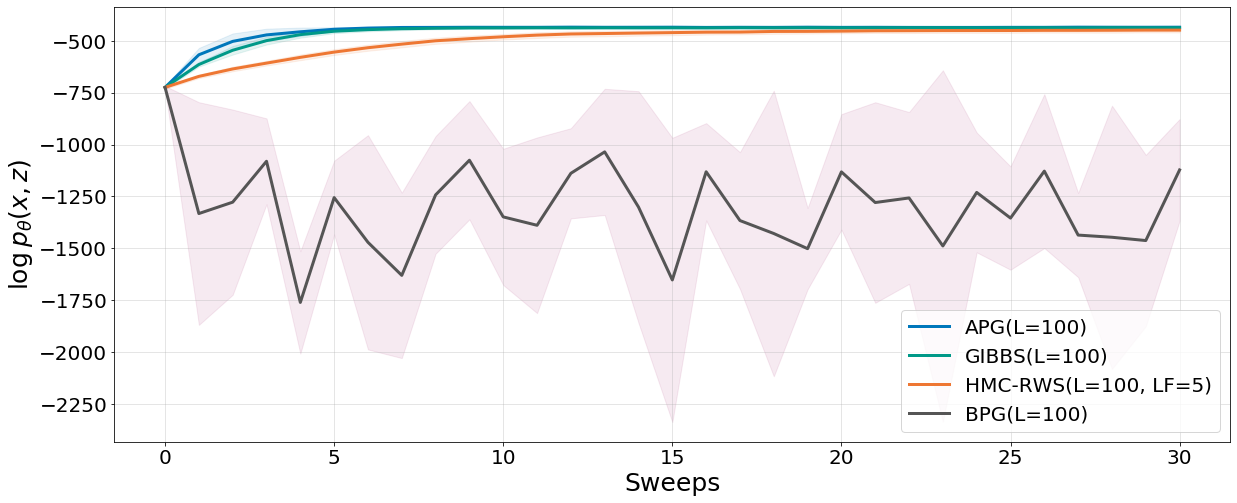

In [18]:
import matplotlib.pyplot as plt
plot_baselines(flags=FLAGs,
               fs=8, 
               fs_title=14, 
               opacity=0.1, 
               lw=3, 
               colors=['#0077BB', '#009988', '#EE7733', '#AA3377', '#555555', '#999933'])